In [35]:
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('/content/jupyter/mta-accessibility')
# from src.data import process_turnstile
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import math 
%matplotlib inline
%config Completer.use_jedi = False

In [159]:
df = pd.read_pickle('../../data/processed/all_turnstiles_with_outage.pkl.gz')

In [160]:
df = df[df.datetime.notnull()]

In [161]:
def is_private(x):
    if pd.isna(x):
        return np.NaN
    else:
        if x.rfind('X') > 0:
            return 'Private'
        else:
            return 'MTA'

In [162]:
df.set_index('datetime',inplace=True)
df['flow'] = df['entry_diff_abs'] + df['exit_diff_abs']
df['maintained'] = [is_private(x) for x in df.equipment_id.values]
df.head()

,STATION,UNIT,equipment_id,station_name,Percentage,entry_diff_abs,exit_diff_abs,Planned Outage,subway_lines,flow,maintained
datetime,,,,,,,,,,,
2019-01-01 00:00:00,103 ST,R191,NaN,NaN,0.0,1892.00,840.0,NaN,NaN,2732.00,NaN
2019-01-01 00:00:00,103 ST,R191,NaN,NaN,0.0,1892.00,840.0,NaN,NaN,2732.00,NaN
2019-01-01 01:00:00,103 ST,R191,NaN,NaN,0.0,1558.75,790.0,NaN,NaN,2348.75,NaN
2019-01-01 02:00:00,103 ST,R191,NaN,NaN,0.0,1225.50,740.0,NaN,NaN,1965.50,NaN
2019-01-01 03:00:00,103 ST,R191,NaN,NaN,0.0,892.25,690.0,NaN,NaN,1582.25,NaN


In [163]:
len(df.STATION.unique())

380

Althought there are 472 stations, turnstile data only has 380 listed

## Analysis plan

- Downtime measure
    - Identify worst equipments & stations
    - Compare privately maintained vs. MTA maintained
    - Daily/monthly aggregations including/excluding Planned outages
- Commuter impact
    - Scale downtime by % all commuters traveling through that station during outage times
    - Identify worst equipments & stations. Compare against downtime measure 
    - Are privately maintained equipments still worst offenders?
    - Daily/monthly aggregations
- Integrate Elevator network
    - Try to replicate MTA Accessibility Dashboard metric (which represents connections from street to platform)
    - Assign weights to elevators depending on intra-subway paths that the elevator disconnects

### Downtime measure
Ratio of time equipment is out to the total time expected to be operating

In [173]:
## looking at only elevators
df_elevators = df[(df.equipment_id.notnull()) & (df.equipment_id.str.contains('EL'))]
df_escalators = df[(df.equipment_id.notnull()) & (df.equipment_id.str.contains('ES'))]

#### Worst equipments/stations

In [165]:
daily_downtime_by_el = df_elevators.groupby([df_elevators.index.floor('d'),'equipment_id','maintained']).sum()['Percentage'].div(df_elevators.groupby([df_elevators.index.floor('d'),'equipment_id','maintained']).count()['Percentage']).reset_index()
daily_downtime_by_st = df_elevators.groupby([df_elevators.index.floor('d'),'STATION']).sum()['Percentage'].div(df_elevators.groupby([df_elevators.index.floor('d'),'STATION']).count()['Percentage']).reset_index()

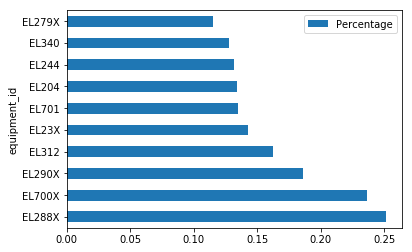

In [166]:
daily_downtime_by_el.groupby('equipment_id').mean().sort_values('Percentage',ascending=False).head(10).plot.barh()

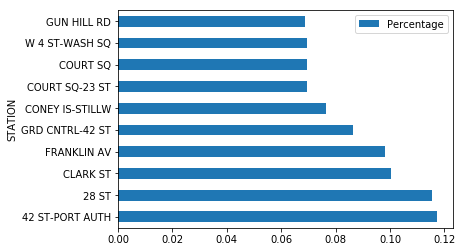

In [167]:
daily_downtime_by_st.groupby('STATION').mean().sort_values('Percentage',ascending=False).head(10).plot.barh()

#### System-wide measure

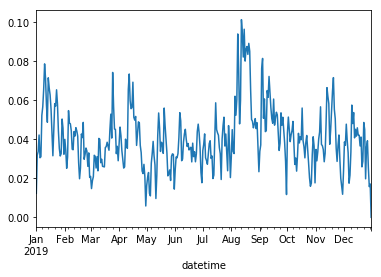

In [168]:
daily_downtime_by_el.groupby('datetime').mean().Percentage.plot()

Text(0.5, 0, 'Month')

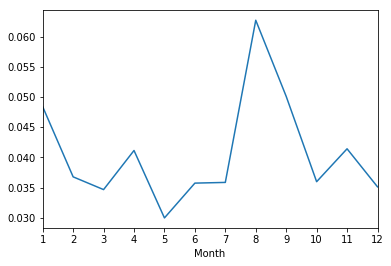

In [169]:
ax = daily_downtime_by_el.groupby(pd.DatetimeIndex(daily_downtime_by_el.datetime).month).mean().Percentage.plot(xticks=range(1,13))
ax.set_xlabel('Month')

#### MTA maintained vs. privately maintained

In [170]:
el_downtime_by_private = daily_downtime_by_el.groupby([pd.DatetimeIndex(daily_downtime_by_el.datetime).month,'maintained']).mean().reset_index()

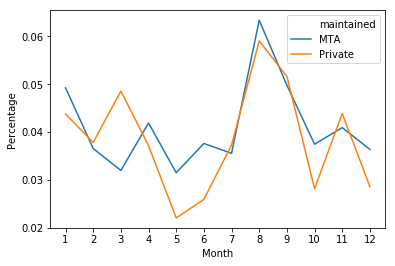

In [172]:
ax = sns.lineplot(x='datetime',y='Percentage',hue='maintained',data=el_downtime_by_private)
ax.set_xlabel('Month')
ax.set_xticks(range(1,13))

#### Excluding planned outages
Planned outages could include Maintenance and Capital replacement. Ideally, we should only exclude capital replacement and probably study the number of commuters impacted during planned maintenance. Until we disaggregate those, excluding all planned outages just for comparison

Text(0.5, 0, 'Month')

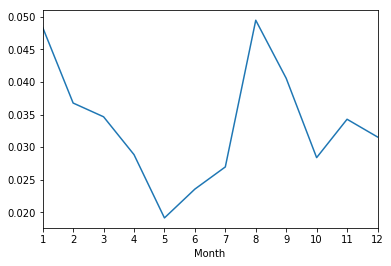

In [185]:
df_el_unplanned = df_elevators[df_elevators['Planned Outage'] != True]
daily_downtime_by_el_up = df_el_unplanned.groupby([df_el_unplanned.index.floor('d'),'equipment_id','maintained']).sum()['Percentage'].div(df_el_unplanned.groupby([df_el_unplanned.index.floor('d'),'equipment_id','maintained']).count()['Percentage']).reset_index()
ax = daily_downtime_by_el_up.groupby(pd.DatetimeIndex(daily_downtime_by_el_up.datetime).month).mean().Percentage.plot(xticks=range(1,13))
ax.set_xlabel('Month')

### Escalators

In [174]:
daily_downtime_by_es = df_escalators.groupby([df_escalators.index.floor('d'),'equipment_id','maintained']).sum()['Percentage'].div(df_escalators.groupby([df_escalators.index.floor('d'),'equipment_id','maintained']).count()['Percentage']).reset_index()
es_downtime_by_private = daily_downtime_by_es.groupby([pd.DatetimeIndex(daily_downtime_by_es.datetime).month,'maintained']).mean().reset_index()

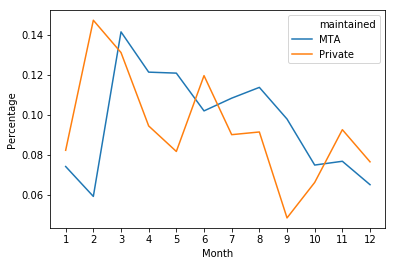

In [175]:
ax = sns.lineplot(x='datetime',y='Percentage',hue='maintained',data=es_downtime_by_private)
ax.set_xlabel('Month')
ax.set_xticks(range(1,13))

### Commuter impact

#### Commuter hours downtime  
Number of commuters at each hour of outage at each station / total number of commuters at that station

In [107]:
df_elevators['flow_pct'] = df_elevators['flow']*df_elevators['Percentage']
daily_ch_dt_by_el = df_elevators.groupby([df_elevators.index.floor('d'),'equipment_id']).sum()['flow_pct'].div(df_elevators.groupby([df_elevators.index.floor('d'),'equipment_id']).sum()['flow']).reset_index()

/opt/conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [108]:
daily_ch_dt_by_el.rename(columns={0:'commuter_hrs_dt'},inplace=True)
daily_ch_dt_by_el.groupby('equipment_id').mean().sort_values('commuter_hrs_dt',ascending=False).head(10)

,commuter_hrs_dt
equipment_id,
EL288X,0.244290
EL700X,0.240558
EL290X,0.184827
EL312,0.162002
EL701,0.135528
EL23X,0.135081
EL244,0.131708
EL204,0.130395
EL340,0.125852


#### % of commuters impacted
Each outage weighted by % of commuters across the entire subway system traveling through the station with the outage

In [109]:
total_hourly_commuters = df_elevators.groupby('datetime').sum()['flow']
total_hourly_commuters.head()

datetime
2019-01-01 00:00:00     913972.00
2019-01-01 01:00:00     590865.25
2019-01-01 02:00:00     515261.75
2019-01-01 03:00:00    1718839.75
2019-01-01 04:00:00    1136561.00
Name: flow, dtype: float64

In [110]:
df_elevators = df_elevators.merge(total_hourly_commuters,on='datetime')
df_elevators.rename(columns={'flow_y':'total_flow','flow_x':'flow'},inplace=True)

In [111]:
df_elevators['total_flow_pct'] = df_elevators['flow']/df_elevators['total_flow']
df_elevators['pct_commuters_affected'] = df_elevators['total_flow_pct']*df_elevators['Percentage']

In [112]:
daily_commuters_affected_by_el = df_elevators.groupby([df_elevators.index.floor('d'),'equipment_id']).sum()['pct_commuters_affected'].reset_index()

,datetime,equipment_id,pct_commuters_affected
0,2019-01-01,EL103,0.000000
1,2019-01-01,EL104,0.000000
2,2019-01-01,EL105,0.011688
3,2019-01-01,EL106,0.000000
4,2019-01-01,EL107,0.000000


In [114]:
daily_commuters_affected_by_el.groupby('equipment_id').mean().sort_values('pct_commuters_affected',ascending=False).head(10)

,pct_commuters_affected
equipment_id,
EL288X,0.061266
EL290X,0.045479
EL204,0.038987
EL244,0.037830
EL700X,0.023499
EL209,0.020863
EL206,0.018853
EL228,0.018256
EL296,0.016516
